In [20]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
from tqdm.notebook import tqdm

In [21]:
#!pip install matplotlib

In [22]:
path = "./"

calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))
sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv"))

In [23]:
!ls

20200508(1).ipynb		sample_submission.csv
20200508(2).ipynb		sample_submission.csv.zip
20200517(1).ipynb		sell_prices.csv
20200518(1).ipynb		sell_prices.csv.zip
Untitled1.ipynb			submission.csv
calendar.csv			test_from_1858_till_1913.ipynb
docker_command.txt		test_from_1914_till_1969.ipynb
model.txt			train.bin
sales.csv			url.txt
sales_train_validation.csv	valid_data_label.npz
sales_train_validation.csv.zip


In [24]:
#!apt-get install unzip

In [25]:
#!unzip sales_train_validation.csv.zip

In [26]:
#!unzip sample_submission.csv.zip

In [27]:
#!unzip sell_prices.csv.zip

In [28]:
from sklearn.preprocessing import OrdinalEncoder

def prep_calendar(df):
    df = df.drop(["date", "weekday", "event_name_2", "event_type_2"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    to_ordinal = ["event_name_1", "event_type_1"] 
    df[to_ordinal] = df[to_ordinal].fillna("1")
    df[to_ordinal] = OrdinalEncoder(dtype="int").fit_transform(df[to_ordinal]) + 1
    to_int8 = ["wday", "month", "snap_CA", "snap_TX", "snap_WI"] + to_ordinal
    df[to_int8] = df[to_int8].astype("int8")
    return df

calendar = prep_calendar(calendar)
calendar.head()

,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI
0,11101,1,1,2011,1,1,1,0,0,0
1,11101,2,1,2011,2,1,1,0,0,0
2,11101,3,1,2011,3,1,1,0,0,0
3,11101,4,2,2011,4,1,1,1,1,0
4,11101,5,2,2011,5,1,1,1,0,1


In [29]:
def prep_selling_prices(df):
    gr = df.groupby(["store_id", "item_id"])["sell_price"]
    df["sell_price_rel_diff"] = gr.pct_change()
    df["sell_price_cumrel"] = (gr.shift(0) - gr.cummin()) / (1 + gr.cummax() - gr.cummin())
    df["sell_price_roll_sd7"] = gr.transform(lambda x: x.rolling(7).std())
    to_float32 = ["sell_price", "sell_price_rel_diff", "sell_price_cumrel", "sell_price_roll_sd7"]
    df[to_float32] = df[to_float32].astype("float32")
         
    return df

selling_prices = prep_selling_prices(selling_prices)
selling_prices.head(14)

,store_id,item_id,wm_yr_wk,sell_price,sell_price_rel_diff,sell_price_cumrel,sell_price_roll_sd7
0,CA_1,HOBBIES_1_001,11325,9.58,NaN,0.0,NaN
1,CA_1,HOBBIES_1_001,11326,9.58,0.000000,0.0,NaN
2,CA_1,HOBBIES_1_001,11327,8.26,-0.137787,0.0,NaN
3,CA_1,HOBBIES_1_001,11328,8.26,0.000000,0.0,NaN
4,CA_1,HOBBIES_1_001,11329,8.26,0.000000,0.0,NaN
5,CA_1,HOBBIES_1_001,11330,8.26,0.000000,0.0,NaN
6,CA_1,HOBBIES_1_001,11331,8.26,0.000000,0.0,6.440940e-01
7,CA_1,HOBBIES_1_001,11332,8.26,0.000000,0.0,4.989131e-01
8,CA_1,HOBBIES_1_001,11333,8.26,0.000000,0.0,1.360284e-08
9,CA_1,HOBBIES_1_001,11334,8.26,0.000000,0.0,1.360284e-08


In [30]:
def reshape_sales(df, drop_d = None):
    if drop_d is not None:
        df = df.drop(["d_" + str(i+1) for i in range(drop_d-1)], axis=1)
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])
    df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int64"))

    return df

sales = reshape_sales(sales, 1000)

In [31]:
ids = sales.columns[sales.columns.str.contains("id")]

In [32]:
ids = ids[:1]
#ids = ids[:2]
print(ids)

Index(['id'], dtype='object')


In [33]:
'''
def prep_sales(df):
    df['lag_t28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    df['rolling_mean_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df['rolling_mean_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df['rolling_mean_t60'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(60).mean())
    df['rolling_mean_t90'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    df['rolling_mean_t180'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df['rolling_std_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df['rolling_std_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
  
    to_float32 = ['lag_t28', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 
                  'rolling_mean_t90', 'rolling_mean_t180', 'rolling_std_t7', 'rolling_std_t30']
    df[to_float32] = df[to_float32].astype("float32")
    
    # Remove rows with NAs except for submission rows. rolling_mean_t180 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df.rolling_mean_t180))]
 
    return df

sales = prep_sales(sales)
'''

'\ndef prep_sales(df):\n    df[\'lag_t28\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28))\n    df[\'rolling_mean_t7\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(7).mean())\n    df[\'rolling_mean_t30\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(30).mean())\n    df[\'rolling_mean_t60\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(60).mean())\n    df[\'rolling_mean_t90\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(90).mean())\n    df[\'rolling_mean_t180\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(180).mean())\n    df[\'rolling_std_t7\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(7).std())\n    df[\'rolling_std_t30\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(30).std())\n  \n    to_float32 = [\'lag_t28\', \'rolling_mean_t7\', \'rolling_mean_t30

In [34]:
'''
def prep_sales_ex(df, subid=None):
    new_col_01 = 'lag_t28_' + subid
    new_col_02 = 'rolling_mean_t7_' + subid
    new_col_03 = 'rolling_mean_t30_' + subid
    new_col_04 = 'rolling_mean_t60_' + subid
    new_col_05 = 'rolling_mean_t90_' + subid
    new_col_06 = 'rolling_mean_t180_' + subid
    new_col_07 = 'rolling_std_t7_' + subid
    new_col_08 = 'rolling_std_t30_' + subid
    #new_col_09 = 'rolling_std_t60_' + subid
    new_col_09 = 'rolling_mean_t14_' + subid
    df[new_col_01] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28))
    df[new_col_02] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df[new_col_03] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df[new_col_04] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(60).mean())
    df[new_col_05] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    df[new_col_06] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df[new_col_07] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df[new_col_08] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
    #df[new_col_09] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(60).std())
    df[new_col_09] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*2).std())
  
    to_float32 = [new_col_01, new_col_02, new_col_03, new_col_04, new_col_05, new_col_06, new_col_07, new_col_08, new_col_09]
    df[to_float32] = df[to_float32].astype("float32")
    
    # Remove rows with NAs except for submission rows. rolling_mean_t180 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df[new_col_06]))]
 
    return df

for subid in ids:
    sales = prep_sales_ex(sales, subid=subid)
'''

'\ndef prep_sales_ex(df, subid=None):\n    new_col_01 = \'lag_t28_\' + subid\n    new_col_02 = \'rolling_mean_t7_\' + subid\n    new_col_03 = \'rolling_mean_t30_\' + subid\n    new_col_04 = \'rolling_mean_t60_\' + subid\n    new_col_05 = \'rolling_mean_t90_\' + subid\n    new_col_06 = \'rolling_mean_t180_\' + subid\n    new_col_07 = \'rolling_std_t7_\' + subid\n    new_col_08 = \'rolling_std_t30_\' + subid\n    #new_col_09 = \'rolling_std_t60_\' + subid\n    new_col_09 = \'rolling_mean_t14_\' + subid\n    df[new_col_01] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28))\n    df[new_col_02] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28).rolling(7).mean())\n    df[new_col_03] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28).rolling(30).mean())\n    df[new_col_04] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28).rolling(60).mean())\n    df[new_col_05] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28).roll

In [35]:
sales.d.unique()

array([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010,
       1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021,
       1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032,
       1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043,
       1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054,
       1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065,
       1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076,
       1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087,
       1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098,
       1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109,
       1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120,
       1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131,
       1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142,
       1143, 1144, 1145, 1146, 1147, 1148, 1149, 11

In [36]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1000,0.0
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1000,0.0
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1000,0.0
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1000,1.0
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1000,1.0
...,...,...,...,...,...,...,...,...
29575295,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1969,NaN
29575296,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1969,NaN
29575297,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1969,NaN
29575298,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1969,NaN


In [37]:
'''
def prep_sales_ex(df, subid=None):
    #new_col_01 = 'lag_t7_' + subid
    #new_col_02 = 'lag_t14_' + subid
    #new_col_03 = 'lag_t21_' + subid
    new_col_04 = 'lag_t28_' + subid
    #new_col_05 = 'lag_t63_' + subid
    #new_col_06 = 'lag_t84_' + subid
    #new_col_07 = 'lag_t182_' + subid
    
    new_col_08 = 'rolling_mean_t7_' + subid
    new_col_09 = 'rolling_mean_t14_' + subid
    new_col_10 = 'rolling_mean_t21_' + subid
    new_col_11 = 'rolling_mean_t28_' + subid
    new_col_28 = 'rolling_mean_t35_' + subid
    new_col_29 = 'rolling_mean_t42_' + subid
    new_col_30 = 'rolling_mean_t49_' + subid
    new_col_31 = 'rolling_mean_t56_' + subid
    new_col_12 = 'rolling_mean_t63_' + subid
    new_col_13 = 'rolling_mean_t84_' + subid
    new_col_14 = 'rolling_mean_t182_' + subid
    new_col_27 = 'rolling_mean_t364_' + subid
    
    new_col_15 = 'rolling_std_t7_' + subid
    new_col_16 = 'rolling_std_t14_' + subid
    new_col_17 = 'rolling_std_t21_' + subid
    new_col_18 = 'rolling_std_t28_' + subid
    new_col_19 = 'rolling_std_t35_' + subid
    new_col_20 = 'rolling_std_t42_' + subid
    new_col_21 = 'rolling_std_t49_' + subid
    new_col_22 = 'rolling_std_t56_' + subid
    new_col_23 = 'rolling_std_t63_' + subid
    new_col_24 = 'rolling_std_t84_' + subid
    new_col_25 = 'rolling_std_t182_' + subid
    new_col_26 = 'rolling_std_t364_' + subid
    
    
    #df[new_col_01] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7))
    #df[new_col_02] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*2))
    #df[new_col_03] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*3))
    df[new_col_04] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*4))
    #df[new_col_05] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*9))
    #df[new_col_06] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*12))
    #df[new_col_07] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*26))
    
    df[new_col_08] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df[new_col_09] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*2).mean())
    df[new_col_10] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*3).mean())
    df[new_col_11] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*4).mean())
    df[new_col_28] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*5).mean())
    df[new_col_29] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*6).mean())
    df[new_col_30] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*7).mean())
    df[new_col_31] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*8).mean())
    df[new_col_12] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*9).mean())
    df[new_col_13] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*12).mean())
    df[new_col_14] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*26).mean())
    df[new_col_27] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*26*2).mean())

    df[new_col_15] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df[new_col_16] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*2).std())
    df[new_col_17] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*3).std())
    df[new_col_18] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*4).std())
    df[new_col_19] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*5).std())
    df[new_col_20] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*6).std())
    df[new_col_21] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*7).std())
    df[new_col_22] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*8).std())
    df[new_col_23] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*9).std())
    df[new_col_24] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*12).std())
    df[new_col_25] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*26).std())
    df[new_col_26] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*26*2).std())
  
    to_float32 = [#new_col_01, new_col_02, new_col_03, new_col_04, new_col_05, new_col_06, new_col_07,
                  new_col_04,
                  new_col_08, new_col_09, new_col_10, new_col_11, new_col_28, new_col_29, new_col_30, new_col_31,
                  new_col_12, new_col_13, new_col_14, new_col_27,
                  new_col_15, new_col_16, new_col_17, new_col_18, new_col_19, new_col_20, new_col_21, new_col_22, new_col_23, new_col_24, new_col_25, new_col_26]
    df[to_float32] = df[to_float32].astype("float32")
    
    # Remove rows with NAs except for submission rows. rolling_mean_t182 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df[new_col_26]))]
 
    return df

for subid in ids:
    sales = prep_sales_ex(sales, subid=subid)
'''

'\ndef prep_sales_ex(df, subid=None):\n    #new_col_01 = \'lag_t7_\' + subid\n    #new_col_02 = \'lag_t14_\' + subid\n    #new_col_03 = \'lag_t21_\' + subid\n    new_col_04 = \'lag_t28_\' + subid\n    #new_col_05 = \'lag_t63_\' + subid\n    #new_col_06 = \'lag_t84_\' + subid\n    #new_col_07 = \'lag_t182_\' + subid\n    \n    new_col_08 = \'rolling_mean_t7_\' + subid\n    new_col_09 = \'rolling_mean_t14_\' + subid\n    new_col_10 = \'rolling_mean_t21_\' + subid\n    new_col_11 = \'rolling_mean_t28_\' + subid\n    new_col_28 = \'rolling_mean_t35_\' + subid\n    new_col_29 = \'rolling_mean_t42_\' + subid\n    new_col_30 = \'rolling_mean_t49_\' + subid\n    new_col_31 = \'rolling_mean_t56_\' + subid\n    new_col_12 = \'rolling_mean_t63_\' + subid\n    new_col_13 = \'rolling_mean_t84_\' + subid\n    new_col_14 = \'rolling_mean_t182_\' + subid\n    new_col_27 = \'rolling_mean_t364_\' + subid\n    \n    new_col_15 = \'rolling_std_t7_\' + subid\n    new_col_16 = \'rolling_std_t14_\' + subid\n

In [38]:
def prep_sales_ex(df, subid=None):
    new_col_01 = 'lag_t28_' + subid
    new_col_02 = 'rolling_mean_t7_' + subid
    new_col_03 = 'rolling_mean_t30_' + subid
    new_col_04 = 'rolling_mean_t60_' + subid
    new_col_05 = 'rolling_mean_t90_' + subid
    new_col_06 = 'rolling_mean_t180_' + subid
    new_col_07 = 'rolling_std_t7_' + subid
    new_col_08 = 'rolling_std_t30_' + subid
    new_col_09 = 'rolling_std_t60_' + subid
    new_col_10 = 'rolling_std_t90_' + subid
    new_col_11 = 'rolling_std_t180_' + subid
    df[new_col_01] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28))
    df[new_col_02] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df[new_col_03] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df[new_col_04] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(60).mean())
    df[new_col_05] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    df[new_col_06] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df[new_col_07] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df[new_col_08] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
    df[new_col_09] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(60).std())
    df[new_col_10] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(90).std())
    df[new_col_11] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(180).std())
  
    to_float32 = [new_col_01, new_col_02, new_col_03, new_col_04, new_col_05, new_col_06, new_col_07, new_col_08,
                  new_col_09, new_col_10, new_col_11,]
    df[to_float32] = df[to_float32].astype("float32")
    
    # Remove rows with NAs except for submission rows. rolling_mean_t180 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df[new_col_06]))]
 
    return df

for subid in ids:
    sales = prep_sales_ex(sales, subid=subid)

In [39]:
sales.columns[sales.columns.str.contains("lag_t28")]

Index(['lag_t28_id'], dtype='object')

In [40]:
sales.d.unique()

array([1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217,
       1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228,
       1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239,
       1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250,
       1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1260, 1261,
       1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272,
       1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283,
       1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294,
       1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305,
       1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316,
       1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327,
       1328, 1329, 1330, 1331, 1332, 1333, 1334, 1335, 1336, 1337, 1338,
       1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349,
       1350, 1351, 1352, 1353, 1354, 1355, 1356, 13

In [41]:
# d >= 1914 has no demand (1914 <= d < 1941: validation, d >= 1941: test)
sales[sales["demand"].isnull()]["d"].unique()

array([1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924,
       1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935,
       1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969])

In [42]:
sales.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28_id,rolling_mean_t7_id,rolling_mean_t30_id,rolling_mean_t60_id,rolling_mean_t90_id,rolling_mean_t180_id,rolling_std_t7_id,rolling_std_t30_id,rolling_std_t60_id,rolling_std_t90_id,rolling_std_t180_id
29575295,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29575296,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29575297,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29575298,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29575299,FOODS_3_827_WI_3,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
sales = sales.merge(calendar, how="left", on="d")
gc.collect()
sales.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28_id,rolling_mean_t7_id,...,rolling_std_t180_id,wm_yr_wk,wday,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI
23263865,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,11621,2,6,2016,18,5,0,0,0
23263866,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,11621,2,6,2016,18,5,0,0,0
23263867,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,11621,2,6,2016,18,5,0,0,0
23263868,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,11621,2,6,2016,18,5,0,0,0
23263869,FOODS_3_827_WI_3,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,11621,2,6,2016,18,5,0,0,0


In [44]:
sales = sales.merge(selling_prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])
sales.drop(["wm_yr_wk"], axis=1, inplace=True)
gc.collect()
del selling_prices
sales.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28_id,rolling_mean_t7_id,...,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_cumrel,sell_price_roll_sd7
23263865,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,2.98,0.0,0.333333,1.753098e-08
23263866,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,2.48,0.0,0.285714,0.000000e+00
23263867,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,3.98,0.0,0.000000,2.404665e-08
23263868,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,1.28,0.0,0.000000,0.000000e+00
23263869,FOODS_3_827_WI_3,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,1.00,0.0,0.000000,0.000000e+00


In [45]:
#for i, v in tqdm(enumerate(["item_id", "dept_id", "store_id", "cat_id", "state_id"])):
for i, v in enumerate(["item_id", "dept_id", "store_id", "cat_id", "state_id"]):
    sales[v] = OrdinalEncoder(dtype="int").fit_transform(sales[[v]]).astype("int16") + 1
gc.collect()

22

In [46]:
sales.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28_id,rolling_mean_t7_id,...,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_cumrel,sell_price_roll_sd7
23263865,FOODS_3_823_WI_3,1433,3,1,10,3,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,2.98,0.0,0.333333,1.753098e-08
23263866,FOODS_3_824_WI_3,1434,3,1,10,3,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,2.48,0.0,0.285714,0.000000e+00
23263867,FOODS_3_825_WI_3,1435,3,1,10,3,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,3.98,0.0,0.000000,2.404665e-08
23263868,FOODS_3_826_WI_3,1436,3,1,10,3,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,1.28,0.0,0.000000,0.000000e+00
23263869,FOODS_3_827_WI_3,1437,3,1,10,3,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,1.00,0.0,0.000000,0.000000e+00


In [ ]:
#sales.to_csv("sales.csv")

In [ ]:
# Start from here from next time
#sales = pd.read_csv("sales.csv")

In [47]:
base_features = ['lag_t28_',
                 'rolling_mean_t7_', 'rolling_mean_t30_', 'rolling_mean_t60_', 'rolling_mean_t90_', 'rolling_mean_t180_', 
                 'rolling_std_t7_', 'rolling_std_t30_', 'rolling_std_t60_', 'rolling_std_t90_', 'rolling_std_t180_']
extended_features = []
for subid in ids:
    tmp = [v+subid for v in base_features]
    extended_features.extend(tmp)

In [48]:
extended_features

['lag_t28_id',
 'rolling_mean_t7_id',
 'rolling_mean_t30_id',
 'rolling_mean_t60_id',
 'rolling_mean_t90_id',
 'rolling_mean_t180_id',
 'rolling_std_t7_id',
 'rolling_std_t30_id',
 'rolling_std_t60_id',
 'rolling_std_t90_id',
 'rolling_std_t180_id']

In [49]:
# Covariables used
x = ["wday", "month", "year", 
     "event_name_1", "event_type_1",
     "snap_CA", "snap_TX", "snap_WI",
     "sell_price", "sell_price_rel_diff", "sell_price_cumrel", "sell_price_roll_sd7",
     "item_id", "dept_id", "cat_id", "store_id", "state_id"]

In [78]:
#x.extend(base_features)

In [50]:
x.extend(extended_features)

In [51]:
len(x)

28

In [52]:
x

['wday',
 'month',
 'year',
 'event_name_1',
 'event_type_1',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'sell_price',
 'sell_price_rel_diff',
 'sell_price_cumrel',
 'sell_price_roll_sd7',
 'item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'lag_t28_id',
 'rolling_mean_t7_id',
 'rolling_mean_t30_id',
 'rolling_mean_t60_id',
 'rolling_mean_t90_id',
 'rolling_mean_t180_id',
 'rolling_std_t7_id',
 'rolling_std_t30_id',
 'rolling_std_t60_id',
 'rolling_std_t90_id',
 'rolling_std_t180_id']

In [53]:
test = sales[sales.d >= 1914]
test = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),
                   F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))

# Reduce sales
sales = sales[sales.d < 1914]
gc.collect()

0

In [54]:
test

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28_id,rolling_mean_t7_id,...,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_cumrel,sell_price_roll_sd7,F
21556430,HOBBIES_1_001_CA_1_validation,1438,4,2,1,1,1914,NaN,1.0,1.142857,...,1,1,0,0,0,8.38,0.0,0.051724,6.414270e-02,F1
21556431,HOBBIES_1_002_CA_1_validation,1439,4,2,1,1,1914,NaN,1.0,0.714286,...,1,1,0,0,0,3.97,0.0,0.000000,0.000000e+00,F1
21556432,HOBBIES_1_003_CA_1_validation,1440,4,2,1,1,1914,NaN,0.0,0.285714,...,1,1,0,0,0,2.97,0.0,0.000000,0.000000e+00,F1
21556433,HOBBIES_1_004_CA_1_validation,1441,4,2,1,1,1914,NaN,0.0,3.000000,...,1,1,0,0,0,4.64,0.0,0.230769,1.226143e-08,F1
21556434,HOBBIES_1_005_CA_1_validation,1442,4,2,1,1,1914,NaN,1.0,0.714286,...,1,1,0,0,0,2.88,0.0,0.250000,1.430725e-08,F1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23263865,FOODS_3_823_WI_3_evaluation,1433,3,1,10,3,1969,NaN,NaN,NaN,...,18,5,0,0,0,2.98,0.0,0.333333,1.753098e-08,F28
23263866,FOODS_3_824_WI_3_evaluation,1434,3,1,10,3,1969,NaN,NaN,NaN,...,18,5,0,0,0,2.48,0.0,0.285714,0.000000e+00,F28
23263867,FOODS_3_825_WI_3_evaluation,1435,3,1,10,3,1969,NaN,NaN,NaN,...,18,5,0,0,0,3.98,0.0,0.000000,2.404665e-08,F28
23263868,FOODS_3_826_WI_3_evaluation,1436,3,1,10,3,1969,NaN,NaN,NaN,...,18,5,0,0,0,1.28,0.0,0.000000,0.000000e+00,F28


In [55]:
# "F1" is assined to both d=1914 and 1942, for example
test[test.F == "F1"].d.unique()

array([1914, 1942])

In [56]:
# "F28" is assined to both d=1941 and 1969, for example
test[test.F == "F28"].d.unique()

array([1941, 1969])

In [57]:
import lightgbm as lgb

In [58]:
# One month of validation data
flag = sales.d >= 1914 - 28
valid = lgb.Dataset(sales[flag][x], label = sales[["demand"]][flag])
#np.savez('valid_data_label', data=sales[flag][x], label=sales[["demand"]][flag])
gc.collect()

# Rest is used for training
sales = sales[~flag].drop(["d", "id"], axis=1)
del flag
gc.collect()
sales = lgb.Dataset(sales[x], label = sales[["demand"]])

# Trick to avoid memory spike when LightGBM converts everything to float32:
#   See https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/53773
#sales.save_binary('train.bin')
#sales = lgb.Dataset('train.bin')

In [59]:
params = {
    'metric': 'rmse',
    'objective': 'poisson',
    'seed': 20,
    'learning_rate': 0.08,
    'lambda': 0.1,
    'num_leaves': 63,
    'bagging_fraction': 0.7,
    'bagging_freq': 1, 
    'colsample_bytree': 0.7
}

fit = lgb.train(params, 
                sales, 
                num_boost_round = 2100, 
                valid_sets = [valid], 
                early_stopping_rounds = 400,
                verbose_eval = 100)

Training until validation scores don't improve for 400 rounds
[100]	valid_0's rmse: 2.24897
[200]	valid_0's rmse: 2.21742
[300]	valid_0's rmse: 2.19576
[400]	valid_0's rmse: 2.17942
[500]	valid_0's rmse: 2.17138
[600]	valid_0's rmse: 2.16266
[700]	valid_0's rmse: 2.15367
[800]	valid_0's rmse: 2.14673
[900]	valid_0's rmse: 2.1444
[1000]	valid_0's rmse: 2.14116
[1100]	valid_0's rmse: 2.14109
[1200]	valid_0's rmse: 2.13848
[1300]	valid_0's rmse: 2.13659
[1400]	valid_0's rmse: 2.13311
[1500]	valid_0's rmse: 2.13209
[1600]	valid_0's rmse: 2.13134
[1700]	valid_0's rmse: 2.13013
[1800]	valid_0's rmse: 2.1303
[1900]	valid_0's rmse: 2.13067
[2000]	valid_0's rmse: 2.13041
[2100]	valid_0's rmse: 2.12827
Did not meet early stopping. Best iteration is:
[2091]	valid_0's rmse: 2.12823


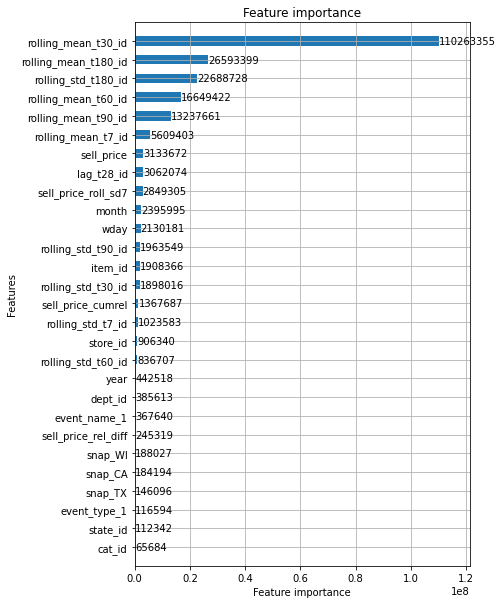

In [60]:
lgb.plot_importance(fit, importance_type="gain", precision=0, height=0.5, figsize=(6, 10));

In [ ]:
# Validation & Visualization
'''

print('Saving model...')
# save model to file
fit.save_model('model.txt')

print('Loading model to predict...')
# load model to predict
fit = lgb.Booster(model_file='model.txt')


npz = np.load("./valid_data_label.npz")
valid_data = npz["data"]
#valid_data

valid_label = npz["label"]
#valid_label

pred = fit.predict(valid_data)

#plt.figure(14, 6)
plt.plot(range(28), valid_label[:28], color='blue')
plt.plot(range(28), pred[:28], color='red');
'''

In [61]:
pred = fit.predict(test[x])
pred

array([0.87795252, 0.45361604, 0.51717447, ..., 0.10384614, 0.06656133,
       0.087945  ])

In [62]:
pred.shape

(1707440,)

In [63]:
test.shape

(1707440, 32)

In [64]:
# The dark magic -> credits: https://www.kaggle.com/kyakovlev/m5-dark-magic
pred_calibrated = pred / pred[test["id"].str.endswith("validation")].mean() * 1.447147
pred_calibrated.shape

(1707440,)

In [65]:
#test["demand"] = pred
test["demand"] = pred_calibrated
test.shape

(1707440, 32)

In [66]:
test.F.unique()

array(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20',
       'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28'],
      dtype=object)

In [67]:
submission = test.pivot(index="id", columns="F", values="demand").reset_index()[sample_submission.columns]
submission.head()

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.170446,0.166327,0.167033,0.159713,0.187144,0.237960,0.229119,0.178783,0.166327,...,0.153940,0.187155,0.183035,0.137896,0.136864,0.136603,0.136024,0.158252,0.190440,0.167718
1,FOODS_1_001_CA_1_validation,0.829064,0.770267,0.767815,0.744778,1.007343,1.059606,1.050193,0.935243,0.918238,...,1.054618,1.383961,1.160364,1.031387,0.939493,0.968489,0.875763,1.056121,1.322311,1.149195
2,FOODS_1_001_CA_2_evaluation,0.130337,0.128362,0.128964,0.123457,0.145092,0.188418,0.179011,0.139868,0.128362,...,0.122683,0.160614,0.151414,0.107560,0.107178,0.106919,0.106818,0.126492,0.164212,0.135668
3,FOODS_1_001_CA_2_validation,0.881270,0.886712,0.885777,0.869094,0.972180,1.048218,0.740596,0.800909,0.868087,...,0.912754,0.912061,1.539089,0.931272,1.010855,0.899708,1.262340,1.091935,1.268014,1.568374
4,FOODS_1_001_CA_3_evaluation,0.188235,0.180736,0.182555,0.183965,0.199802,0.248198,0.239407,0.192524,0.180736,...,0.160170,0.181294,0.176391,0.139374,0.141466,0.141879,0.135731,0.147415,0.176841,0.165554


In [68]:
submission.to_csv("submission.csv", index=False)

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200505(2)" # df[new_col_09] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*2).std()) added

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200505(3)" 
''' with base_features = ['lag_t7_', 'lag_t14_', 'lag_t21_', 'lag_t28_', 'lag_t63_', 'lag_t84_', 'lag_t182_', 
                          'rolling_mean_t7_', 'rolling_mean_t14_', 'rolling_mean_t21_', 'rolling_mean_t28_', 'rolling_mean_t63_', 'rolling_mean_t84_', 'rolling_mean_t182_',
                          'rolling_std_t7_', 'rolling_std_t14_', 'rolling_std_t21_', 'rolling_std_t28_', 'rolling_std_t63_', 'rolling_std_t84_', 'rolling_std_t182_']
'''

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200506(1) remove from lag7 from lag182 but lag28"  # 0.54475

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200506(2) increase num of leaves from 63 to 63*2" # 0.54823

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200506(3) reduce learning rate from 0.08 to 0.04 and increase num boost round from 2100 to 4200" # 0.54979

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200507(1) add std35, std42, std49 and std56" # 0.54771

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200507(2) add std364" # 0.55362

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200507(3) add mean364" # 0.56688

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200508(1) add mean35" # 0.56041

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200508(2) add mean42, mean49 and mean56" # 0.55153

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200518(1) regressed to 20200506(1)" # 0.55230